In [2]:
# load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("data/heart.csv")

In [3]:
data.head() # an overview on data 

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


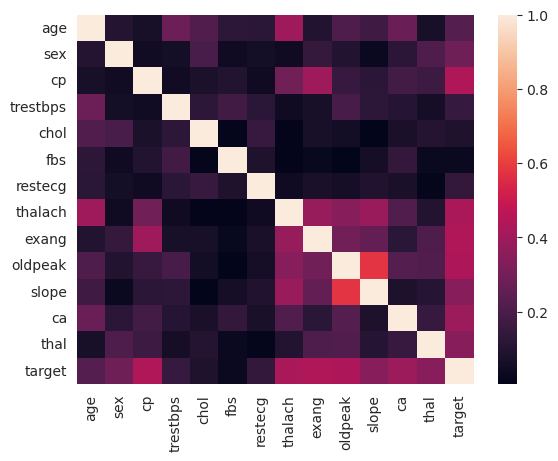

In [5]:
dataplot = sns.heatmap(abs(data.corr()))

Despite the fact that this graph is useful for data analysis in this specific homework we will need to focus only on two features with the highest correlation.

In [23]:
# displaying correlations for target column
abs(data.corr()["target"])

age         0.225439
sex         0.280937
cp          0.433798
trestbps    0.144931
chol        0.085239
fbs         0.028046
restecg     0.137230
thalach     0.421741
exang       0.436757
oldpeak     0.430696
slope       0.345877
ca          0.391724
thal        0.344029
target      1.000000
Name: target, dtype: float64

As we could see 2 biggest correlation are:
 - *cp* - it's the type of chest pain the patient have. 
 - *exang* - Exercise induced angina. 
> For NOTE: angina - is chest pain caused usually by insufficient blood flow.

Although this correlation are the biggest one, for showing decision boundary I will choose:
 - thalach - The person's   maximum heart rate achieved
 - oldpeak - ST depression induced by exercise relative to rest    

In [6]:
selected_columns = data[["thalach", "oldpeak", "target"]] 
selected_columns.head()

,thalach,oldpeak,target
0,150,2.3,1
1,187,3.5,1
2,172,1.4,1
3,178,0.8,1
4,163,0.6,1


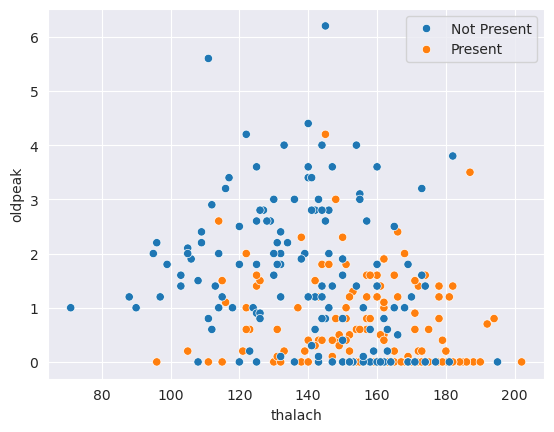

In [16]:
# a look on the data



ax = sns.scatterplot(x="thalach", y="oldpeak", hue="target", data = selected_columns, legend=["no heart-diseases", "heart-diseases"])

handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles, ["Not Present", "Present"])

Here could be observed and aggregation of _Present_ in the right-lower corner. And a concentration of _Not-Present_  in the center. 

### Logistic Regression

In [8]:
# train prediction model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

model = LogisticRegression()


X = selected_columns.drop(columns=["target"]).to_numpy()
y = selected_columns["target"].to_numpy()

X, X_test, y, y_test = train_test_split(X,y, test_size=0.3)
model.fit(X, y)

yhat = model.predict(X_test)
acc = accuracy_score(y_test, yhat)
print(f"Accuracy: {acc} (LogisticRegression)")

Accuracy: 0.7912087912087912 (LogisticRegression)


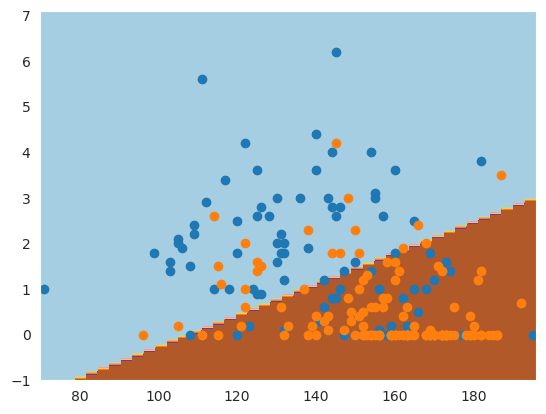

In [9]:
# graphical representation of LogisticRegression  

from matplotlib import pyplot

min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
xx, yy = np.meshgrid(x1grid, x2grid)
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
grid = np.hstack((r1,r2))
yhat = model.predict(grid)
zz = yhat.reshape(xx.shape)
pyplot.contourf(xx, yy, zz, cmap='Paired')

for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y == class_value)
    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1])

Here as was described earlier the logistic-regression separated using a line both target.

### Decision Tree

<Axes: xlabel='thalach', ylabel='oldpeak'>

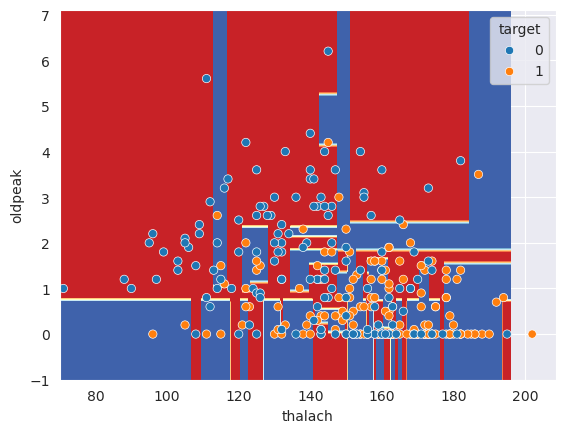

In [10]:
# graphical representation of DecisionTreeClassifier 

from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier().fit(X, y)

plot_step = 0.1

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

sns.scatterplot(x="thalach", y="oldpeak", hue="target", data = selected_columns)


Here could be seen how Decision-Tree delimited target feature. But there could be seen some errors (cause is without tunning).

Accuracy DecisionTreeClassifier: 0.6813186813186813 (without hyperparameters tunning)


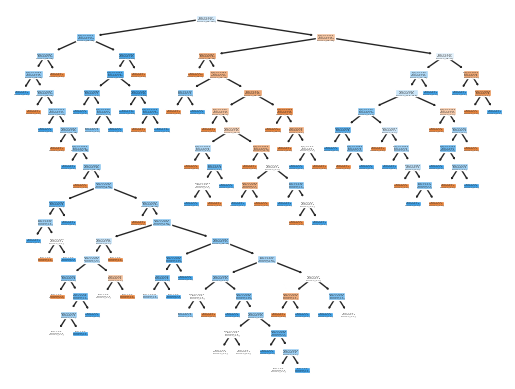

In [11]:
plt.figure()
clf = DecisionTreeClassifier().fit(X, y)
y_predicted = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print(f"Accuracy DecisionTreeClassifier: {accuracy} (without hyperparameters tunning)")
plot_tree(clf, filled=True)
plt.show()

The resulted tree is so complex because there is no max_depth specified which means the algorithm is expanding until all leaves are pure or until all leaves contain less than min_samples_split samples.

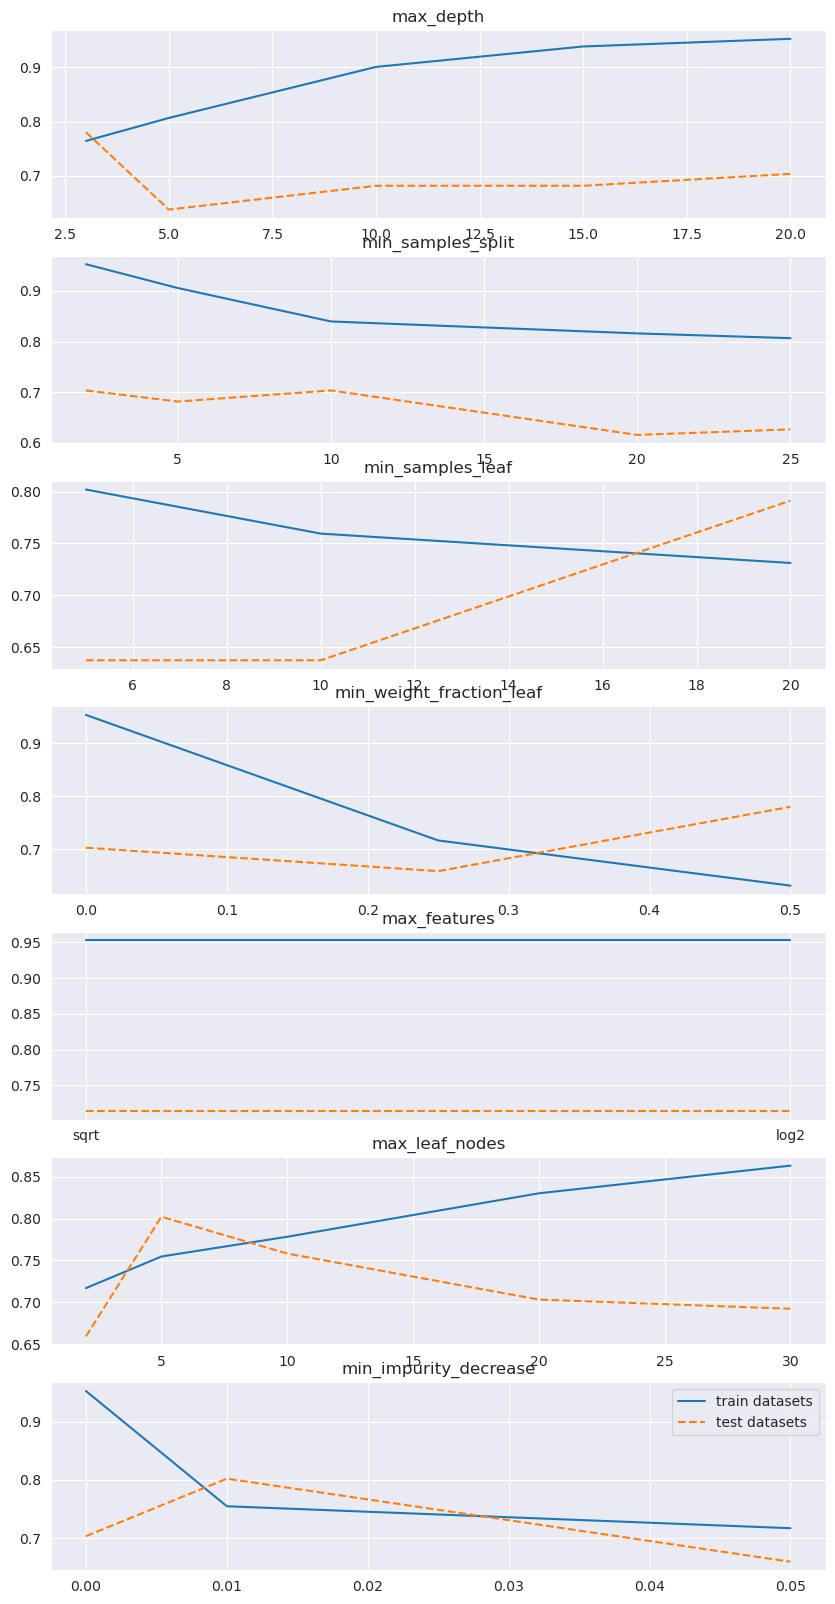

In [12]:

random_state = 42

# setting hyperparameters

params_grid = {
    'max_depth': [3, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10,20,25],
    'min_samples_leaf': [5,10,20],
    'min_weight_fraction_leaf': [0.0, 0.25, 0.5],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [2,5,10, 20, 30],
    'min_impurity_decrease': [0.0, 0.01, 0.05],
}



index = 0 
fig, axs = plt.subplots(len(params_grid),figsize=(10, 20))
for hyperparameter, values in params_grid.items():
    accuracies = []
    accuracies_test = []
    
    for value in values:
        init_parameters = {hyperparameter: value, "random_state": 42}
        clf = DecisionTreeClassifier(**init_parameters)
        clf.fit(X, y) # train for each hyperparmeter
        y_predicted_data = clf.predict(X) 
        y_predicted_test = clf.predict(X_test)
        accuracy = accuracy_score(y, y_predicted_data)
        accuracy_test = accuracy_score(y_test, y_predicted_test)
        accuracies.append(accuracy)
        accuracies_test.append(accuracy_test)
    
    axs[index].plot( values, accuracies, label= "train")
    axs[index].plot( values, accuracies_test, linestyle='--', label ="test")
    axs[index].set_title(hyperparameter)
    index += 1 # crazy algorithms (o_O )
    plt.legend(["train datasets", "test datasets"])

### hyper-parameters

`max_depth` - influence how much in depth the trees  go. also as we could observe the a greater value leads to overfiting. 

 `min_samples_split` -  minimum required nr of samples to split the node,  a lower value leads to overfiting  

`min_sample_leaf` - minimum number of samples required to be at a leaf node. again a lower value leads to overfiting. 

`min_weight_fraction_leaf` - minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. a lower value leads to overfiting 

`max_features` -  the number of features to consider when looking for the best split. don't influence at all 

`max_leaf_nodes` - the number of leafs in total. A lesser value leads to underfiting

`min_inpurity_decrease` -  a node will be split if this split induces a decrease of the impurity greater than.  a smaller value will lead to overfiting 
 

### Conclusion
Generally speaking this hyperparameters influence the overfiting or underfiting. And should be considered to change in dependence of the dataset.

### Best hyperparameters 

In [13]:
# find the best parameters

from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier()

gridscv = GridSearchCV(clf, params_grid, cv=5,return_train_score=True)

gridscv.fit(X, y)
best_fitted_hyperparameters = gridscv.best_params_
best_fitted_hyperparameters

{'max_depth': 3,
 'max_features': 'log2',
 'max_leaf_nodes': 30,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0}

Accuracy DeccisionTreeClasifier: 0.6923076923076923 (with hyperparameters tunning)


[Text(0.5, 0.875, 'x[1] <= 0.75\ngini = 0.491\nsamples = 212\nvalue = [92, 120]'),
 Text(0.25, 0.625, 'x[0] <= 167.0\ngini = 0.357\nsamples = 112\nvalue = [26, 86]'),
 Text(0.125, 0.375, 'x[1] <= 0.35\ngini = 0.425\nsamples = 75\nvalue = [23, 52]'),
 Text(0.0625, 0.125, 'gini = 0.437\nsamples = 59\nvalue = [19, 40]'),
 Text(0.1875, 0.125, 'gini = 0.375\nsamples = 16\nvalue = [4, 12]'),
 Text(0.375, 0.375, 'x[1] <= 0.05\ngini = 0.149\nsamples = 37\nvalue = [3, 34]'),
 Text(0.3125, 0.125, 'gini = 0.17\nsamples = 32\nvalue = [3, 29]'),
 Text(0.4375, 0.125, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.75, 0.625, 'x[1] <= 2.45\ngini = 0.449\nsamples = 100\nvalue = [66, 34]'),
 Text(0.625, 0.375, 'x[0] <= 114.5\ngini = 0.49\nsamples = 70\nvalue = [40, 30]'),
 Text(0.5625, 0.125, 'gini = 0.0\nsamples = 11\nvalue = [11, 0]'),
 Text(0.6875, 0.125, 'gini = 0.5\nsamples = 59\nvalue = [29, 30]'),
 Text(0.875, 0.375, 'x[1] <= 2.95\ngini = 0.231\nsamples = 30\nvalue = [26, 4]'),
 Text(0.8125,

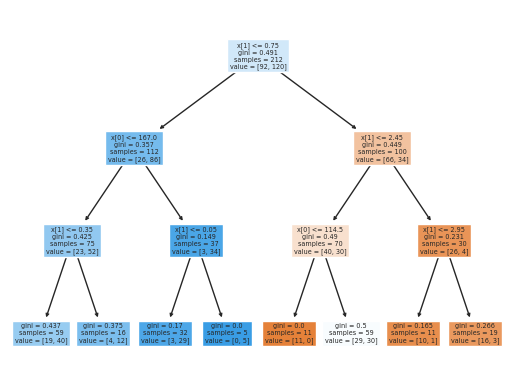

In [14]:
# train with best suited parameters

best_clf = DecisionTreeClassifier(
    **best_fitted_hyperparameters,
) 

best_clf.fit(X,y)
y_predicted = best_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_predicted)
print(f"Accuracy DeccisionTreeClasifier: {accuracy} (with hyperparameters tunning)")
plot_tree(best_clf, filled=True)
 

### Conclusion

| **Model**                               | **Accuracy** |
| --------------------------------------- | ------------ |
| LogisticRegrresion                      | 0.758        |
| DecisionTreeClassifire(without tunning) | 0.571        |
| DecisionTreeClasifire(tunned)           | 0.791        |

DecisionTreeClassifier is a great tool when features are not linear.  
